<a href="https://colab.research.google.com/github/dernameistegal/airbnb_price/blob/main/data_utils/data_preparation/listings_transformations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
!pip install ast
import ast
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

  Using cached AST-0.0.2.tar.gz (19 kB)
  Using cached AST-0.0.1.tar.gz (19 kB)
ERROR: Could not find a version that satisfies the requirement ast (from versions: 0.0.1, 0.0.2)
ERROR: No matching distribution found for ast
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
path= ("/content/drive/MyDrive/Colab/airbnb/data/translations/translated_listings.pickle")
listings = pd.read_pickle(path)

In [32]:
# transform price
listings["price"] = (
    listings["price"].str.replace("$", "").str.replace(",", "").astype(float)
)

In [33]:
#remove zeros
print(len(listings[listings["price"] == 0]))
listings = listings[listings["price"] != 0]

5


In [34]:
# log price
listings["log_price"] = np.log(listings["price"])

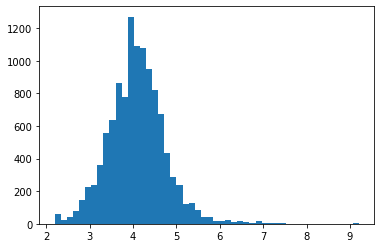

In [35]:
import matplotlib.pyplot as plt
plt.hist(listings["log_price"], bins=50)
plt.show()

In [36]:
# recode rooms, host_is_superhost and host_identity_verified into dummies
rooms = pd.get_dummies(listings["room_type"], prefix="room")
listings = listings.drop("room_type", axis=1)
listings["host_is_superhost"] = listings["host_is_superhost"].map(dict(t=1, f=0))
listings["instant_bookable"] = listings["instant_bookable"].map(dict(t=1, f=0))
listings["host_identity_verified"] = listings["host_identity_verified"].map(
    dict(t=1, f=0)
)
listings = pd.concat([listings, rooms], axis=1)

In [37]:
# remove columns from listings that do not make sense as predictors

drop_vars = ["name", "listing_url", "scrape_id", "last_scraped", "picture_url", 
       "neighborhood_overview", "description", "host_id", 
       "host_url", "host_name", "host_location", "host_about",
       "host_thumbnail_url", "host_picture_url", "host_neighbourhood", "host_total_listings_count",
       "host_has_profile_pic", "neighbourhood", "neighbourhood_group_cleansed", "bathrooms",
       "maximum_nights", "maximum_nights",	"minimum_minimum_nights", 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated',"has_availability", "calendar_last_scraped",
       "number_of_reviews_ltm", "number_of_reviews_l30d", "license"]

listings = listings.drop(drop_vars, axis=1)

In [38]:
# recode host_verifications into dummies
listings["host_verifications"] = listings["host_verifications"].apply(ast.literal_eval)
host_verifications = listings["host_verifications"]
host_verifications = pd.get_dummies(host_verifications.apply(pd.Series).stack(dropna=False), prefix="host_verification").sum(level=0)
listings = pd.concat([listings, host_verifications], axis=1)
listings = listings.drop("host_verifications", axis=1)

In [39]:
# recode property_type into dummies
properties = pd.get_dummies(listings["property_type"], prefix="property_type")
listings = listings.drop("property_type", axis=1)
listings = pd.concat([listings, properties], axis=1)

In [40]:
# recode neighbourhood_cleansed into dummies
neighbourhood_cleansed = pd.get_dummies(listings["neighbourhood_cleansed"], prefix="neighbourhood_cleansed")
listings = listings.drop("neighbourhood_cleansed", axis=1)
listings = pd.concat([listings, neighbourhood_cleansed], axis=1)

In [41]:
# recode amenities into dummies
listings["amenities"] = listings["amenities"].apply(ast.literal_eval)
amenities = listings["amenities"]
amenities = pd.get_dummies(amenities.apply(pd.Series).stack(dropna=False), prefix="amenities").sum(level=0)
listings = pd.concat([listings, amenities], axis=1)
listings = listings.drop("amenities", axis=1)

In [42]:
# recode bath into batch shared dummy and number of baths
bath_is_shared = listings["bathrooms_text"].str.contains("shared", case=False, na=False)
bath_is_shared.name = "bath_is_shared"
bath_is_half = listings["bathrooms_text"].str.contains("half", case=False, na=False)
bath_number = listings["bathrooms_text"].str.extract('(\d+\.?\d?)')
bath_number[bath_is_half] = 0.5
bath_number.name = "bath_number"

listings = pd.concat([listings, bath_is_shared, bath_number], axis=1)
listings = listings.drop("bathrooms_text", axis=1)

In [45]:
listings.head()

,id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_identity_verified,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,maximum_minimum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,description_en,host_about_en,name_en,lang,...,amenities_liebherr refrigerator,amenities_lireal conditioner,amenities_local body soap,amenities_logitech sound system with Bluetooth and aux,amenities_maggie shampoo,amenities_miele refrigerator,amenities_miele stainless steel electric stove,amenities_n/a body soap,amenities_niv shampoo,amenities_nivea body soap,amenities_no name... body soap,"amenities_nur Seife vorhanden, Marke Lux body soap",amenities_o.k. refrigerator,amenities_palmolive body soap,amenities_palmolive conditioner,amenities_ph neutral soap and shampoo body soap,amenities_portable stove induction stove,amenities_quin conditioner,amenities_quin shampoo,amenities_regular refrigerator,amenities_samsung refrigerator,amenities_siemens stainless steel electric stove,amenities_simens stainless steel electric stove,amenities_sonos sound system,amenities_standard body soap,amenities_there is a CD player and a radio. Basic but nice. sound system with aux,"amenities_there is usually shower gel from an ecological brand in the shower. Also sometimes body lotion samples. If you forgot your toothbrush, or toothpaste, there is one to buy prepared in the bathroom. There are some emergency tampons, hair scrunches and so on. body soap",amenities_unbekannt refrigerator,amenities_unbekannt body soap,amenities_unbekannt in Einbauküche refrigerator,amenities_various conditioner,amenities_variouse body soap,amenities_verschiedene body soap,amenities_verschiedene shampoo,amenities_verschiedene Marken body soap,amenities_verschiedene body soap,amenities_whirlpool oven,amenities_wirlpool refrigerator,bath_is_shared,0
5339,28040371,2017-08-14,NaN,NaN,NaN,0.0,1.0,1.0,48.175930,16.282230,5,2.0,3.0,96.0,2,2,23,44,74,294,48,2018-09-22,2018-10-03,4.90,4.92,4.90,4.94,4.85,4.88,4.79,0,1,1,0,0,1.26,The Appartment Lainz is a beautiful apartment ...,no text,Appartment Lainz,de,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,1
9593,48182190,2021-06-01,NaN,NaN,NaN,0.0,76.0,0.0,48.196712,16.345419,3,1.0,2.0,70.0,1,2,21,47,77,100,31,2021-02-28,2021-11-01,4.42,4.61,4.42,4.55,4.61,4.74,4.48,1,68,59,9,0,3.66,A beautiful and modern room in the middle of t...,no text,Shopping Paradise Triple Room Mariahilfer Str. I,de,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,1
9592,48182112,2021-06-01,NaN,NaN,NaN,0.0,76.0,0.0,48.196709,16.345516,2,1.0,1.0,62.0,1,1,17,46,76,99,22,2021-03-23,2021-10-03,4.45,4.64,4.59,4.36,4.59,4.82,4.36,1,68,59,9,0,2.86,A nice and modern room in the middle of the fa...,no text,Shopping Paradise w/ City View Mariahilfer Str. H,de,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,1
9591,48180447,2018-11-26,NaN,NaN,51%,0.0,2.0,1.0,48.169100,16.377960,6,2.0,4.0,120.0,1,1,0,0,0,0,6,2021-02-21,2021-02-23,4.83,5.00,4.83,5.00,5.00,4.83,5.00,0,1,1,0,0,0.69,The apartment is about 97sqm large and has an ...,no text,Modern penthouse apartment in the middle of Vi...,de,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,1.5
9590,48178023,2020-01-03,within an hour,100%,100%,1.0,0.0,1.0,48.233350,16.381290,5,1.0,4.0,65.0,2,2,0,0,30,120,7,2021-05-10,2021-09-30,5.00,5.00,5.00,5.00,5.00,4.86,5.00,1,4,4,0,0,1.15,In the beautiful cl

In [ ]:
# save transformed listings

path = ("/content/drive/MyDrive/Colab/airbnb/data/translations/listings_workfile.pickle")
listings.to_pickle(path)